1. Problem Statement

* This project is trying to understand mai NFL indicators and 

First we are goiong get the data from kaggle https://www.kaggle.com/datasets/philiphyde1/nfl-stats-1999-2022




Importing Pandas, Numpy, Matplotlib, Seaborn and Warnings library

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import os
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Matplotlib is building the font cache; this may take a moment.
c:\Users\jb255070\Documents\NFL_python_project\nfl_ml_project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import the data from kaggle with the kaggle hub package


In [9]:
# download the data from kaggle
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("philiphyde1/nfl-stats-1999-2022")


In [14]:
# Print the folder path
print(f"Dataset downloaded to: {dataset_path}")

# List files in the dataset folder
print("Files in the dataset folder:", os.listdir(dataset_path))

Dataset downloaded to: C:\Users\jb255070\.cache\kagglehub\datasets\philiphyde1\nfl-stats-1999-2022\versions\11
Files in the dataset folder: ['weekly_player_stats_defense.csv', 'weekly_player_stats_offense.csv', 'weekly_team_stats_defense.csv', 'weekly_team_stats_offense.csv', 'yearly_player_stats_defense.csv', 'yearly_player_stats_offense.csv', 'yearly_team_stats_defense.csv', 'yearly_team_stats_offense.csv']


In [152]:
# Load the CSV file into a DataFrame
# [weekly_player_stats_defense.csv'', 'weekly_player_stats_offense.csv', 'weekly_team_stats_defense.csv', 'weekly_team_stats_offense.csv', 'yearly_player_stats_defense.csv', 'yearly_player_stats_offense.csv', 'yearly_team_stats_defense.csv', 'yearly_team_stats_offense.csv']
weekly_df_offense = pd.read_csv(os.path.join(dataset_path, 'weekly_player_stats_defense.csv'))


# We are starting with the Exploratory data analysis. The first think is to  know how many columns and rows we have in the dataset. We know that we have weekly granularity 

In [171]:
num_columns = weekly_df_offense.shape[1]
num_rows = weekly_df_offense.shape[0]
column_names = weekly_df_offense.columns.tolist()
print(f"The dataset has {num_columns} columns and {num_rows} rows")
for col in column_names:
    print(f"Column: {col}, Type: {weekly_df_offense[col].dtype}, Unique Values: {weekly_df_offense[col].nunique()}")


The dataset has 112 columns and 120185 rows
Column: player_id, Type: object, Unique Values: 4899
Column: player_name, Type: object, Unique Values: 4830
Column: position, Type: object, Unique Values: 22
Column: birth_year, Type: int64, Unique Values: 30
Column: draft_year, Type: float64, Unique Values: 29
Column: draft_round, Type: float64, Unique Values: 8
Column: draft_pick, Type: float64, Unique Values: 46
Column: draft_ovr, Type: float64, Unique Values: 259
Column: height, Type: float64, Unique Values: 16
Column: weight, Type: float64, Unique Values: 185
Column: college, Type: object, Unique Values: 348
Column: team, Type: object, Unique Values: 32
Column: season, Type: int64, Unique Values: 13
Column: season_type, Type: object, Unique Values: 2
Column: week, Type: int64, Unique Values: 22
Column: solo_tackle, Type: float64, Unique Values: 23
Column: assist_tackle, Type: float64, Unique Values: 18
Column: tackle_with_assist, Type: float64, Unique Values: 16
Column: sack, Type: float

In [176]:
weekly_df_offense.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120185 entries, 0 to 120184
Columns: 112 entries, player_id to career_average_team_defense_snaps
dtypes: float64(99), int64(6), object(7)
memory usage: 102.7+ MB


First we will have to define the problem. We are trying to predict total tackles and assists per game. The first thing is that we have to define what total tackles and assists are defined in American Football.

The concept of an assist in American football is different from assists in other sports. Assists involve cooperation between defenders during tacles "this part of the definition gives us a bit of information, as total tackles and assists are a defense statistic. 

An assisted tackle occurs when two or more defenders tackle an opponent together.

Starting out with univariate statistics

In [193]:
weekly_df_offense[['player_id','position','team',
                   'season','week', 'solo_tackle', 
                   'assist_tackle', 'tackle_with_assist']]

,player_id,position,team,season,week,solo_tackle,assist_tackle,tackle_with_assist
0,00-0000551,ILB,BAL,2012,6,0.0,1.0,1.0
1,00-0000551,ILB,BAL,2012,12,2.0,2.0,2.0
2,00-0000551,ILB,BAL,2012,13,3.0,0.0,0.0
3,00-0000551,ILB,BAL,2012,14,1.0,6.0,2.0
4,00-0000551,ILB,BAL,2012,15,3.0,6.0,6.0
...,...,...,...,...,...,...,...,...
120180,00-0039924,DE,MIN,2024,16,2.0,1.0,1.0
120181,00-0039924,DE,MIN,2024,17,4.0,0.0,0.0
120182,00-0039924,DE,MIN,2024,18,1.0,0.0,0.0
120183,00-0039924,DE,MIN,2024,19,0.0,1.0,0.0


In [204]:
# We are going to filter by season, we will want to analyze only seasons from 2023 onwards

weekly_df_offense_filtered = weekly_df_offense[weekly_df_offense['season'].isin([2022,2023,2024])][[
    'player_id', 'position', 'team', 'season', 'week',
    'solo_tackle', 'assist_tackle', 'tackle_with_assist'
]]

weekly_df_offense_filtered['total_tackles_and_assists'] = (
    weekly_df_offense_filtered['solo_tackle'] +
    weekly_df_offense_filtered['assist_tackle'] +
    weekly_df_offense_filtered['tackle_with_assist']
)
weekly_df_offense_filtered.head()

,player_id,position,team,season,week,solo_tackle,assist_tackle,tackle_with_assist,total_tackles_and_assists
90881,00-0019596,QB,SEA,2022,10,1.0,0.0,0.0,1.0
90882,00-0026143,QB,HOU,2022,1,1.0,0.0,0.0,1.0
90883,00-0026158,QB,BAL,2022,1,1.0,0.0,0.0,1.0
90884,00-0026166,T,DET,2022,15,1.0,0.0,0.0,1.0
90885,00-0026166,T,JAX,2022,16,1.0,0.0,0.0,1.0


In [205]:
# How many tackles per player ID
weekly_df_offense_filtered.groupby('player_id')[['solo_tackle', 'assist_tackle', 'tackle_with_assist', 'total_tackles_and_assists']].sum(numeric_only=True)

,solo_tackle,assist_tackle,tackle_with_assist,total_tackles_and_assists
player_id,,,,
00-0019596,1.0,0.0,0.0,1.0
00-0026143,1.0,0.0,0.0,1.0
00-0026158,2.0,1.0,0.0,3.0
00-0026166,3.0,0.0,0.0,3.0
00-0026189,1.0,0.0,0.0,1.0
...,...,...,...,...
00-0039919,1.0,0.0,0.0,1.0
00-0039920,1.0,0.0,0.0,1.0
00-0039921,2.0,0.0,0.0,2.0


In [206]:
# Exploratory metrics by player, however the table is a bit hard to read, let's see if groupbing by season we can interpret better the information

weekly_df_offense_filtered.groupby('player_id')[['solo_tackle', 'assist_tackle', 'tackle_with_assist', 'total_tackles_and_assists']].describe()

solo_tackle                                     assist_tackle       \
                 count mean  std  min   25%  50%  75%  max         count mean   
player_id                                                                       
00-0019596         1.0  1.0  NaN  1.0  1.00  1.0  1.0  1.0           1.0  0.0   
00-0026143         1.0  1.0  NaN  1.0  1.00  1.0  1.0  1.0           1.0  0.0   
00-0026158         2.0  1.0  0.0  1.0  1.00  1.0  1.0  1.0           2.0  0.5   
00-0026166         3.0  1.0  0.0  1.0  1.00  1.0  1.0  1.0           3.0  0.0   
00-0026189         1.0  1.0  NaN  1.0  1.00  1.0  1.0  1.0           1.0  0.0   
...                ...  ...  ...  ...   ...  ...  ...  ...           ...  ...   
00-0039919         1.0  1.0  NaN  1.0  1.00  1.0  1.0  1.0           1.0  0.0   
00-0039920         1.0  1.0  NaN  1.0  1.00  1.0  1.0  1.0           1.0  0.0   
00-0039921         2.0  1.0  0.0  1.0  1.00  1.0  1.0  1.0           2.0  0.0   
00-0039924        10.0  2.0  2.0  0.0  0.25  1.5  3.5  5.0          10.0  0.9   
00-0039925         1.0  1.0  NaN  1.0  1.00  1.0  1.0  1.0           1.0  1.0   

            ... tackle_with_assist      total_tackles_and_assists       \
            ...                75%  max                     count mean   
player_id   ...                                                          
00-0019596  ...               0.00  0.0                       1.0  1.0   
00-0026143  ...               0.00  0.0                       1.0  1.0   
00-0026158  ...               0.00  0.0                       2.0  1.5   
00-0026166  ...               0.00  0.0                       3.0  1.0   
00-0026189  ...               0.00  0.0                       1.0  1.0   
...         ...                ...  ...                       ...  ...   
00-0039919  ...               0.00  0.0                       1.0  1.0   
00-0039920  ...               0.00  0.0                       1.0  1.0   
00-0039921  ...               0.00  0.0                       2.0  1.0   
00-0039924  ...               0.75  1.0                      10.0  3.2   
00-0039925  ...               0.00  0.0                       1.0  2.0   

                                                 
                 std  min   25%  50%   75%  max  
player_id                                        
00-0019596       NaN  1.0  1.00  1.0  1.00  1.0  
00-0026143       NaN  1.0  1.00  1.0  1.00  1.0  
00-0026158  0.707107  1.0  1.25  1.5  1.75  2.0  
00-0026166  0.000000  1.0  1.00  1.0  1.00  1.0  
00-0026189       NaN  1.0  1.00  1.0  1.00  1.0  
...              ...  ...   ...  ...   ...  ...  
00-0039919       NaN  1.0  1.00  1.0  1.00  1.0  
00-0039920       NaN  1.0  1.00  1.0  1.00  1.0  
00-0039921  0.000000  1.0  1.00  1.0  1.00  1.0  
00-0039924  2.299758  1.0  1.25  2.5  4.00  7.0  
00-0039925       NaN  2.0  2.00  2.0  2.00  2.0  

[1962 rows x 32 columns]

In [207]:
# Exploratory metrics by season, the data is still unreadeable, let's do colum by colum starting out with solo tackle and ending with totals

weekly_df_offense_filtered.groupby('season')[['solo_tackle', 'assist_tackle', 'tackle_with_assist', 'total_tackles_and_assists']].describe()

solo_tackle                                                \
             count      mean       std  min  25%  50%  75%   max   
season                                                             
2022        9725.0  2.590746  2.414161  0.0  1.0  2.0  4.0  17.0   
2023        9804.0  2.586393  2.428196  0.0  1.0  2.0  4.0  22.0   
2024        9775.0  2.545985  2.367873  0.0  1.0  2.0  4.0  17.0   

       assist_tackle            ... tackle_with_assist        \
               count      mean  ...                75%   max   
season                          ...                            
2022          9725.0  1.754036  ...                1.0  11.0   
2023          9804.0  1.796002  ...                1.0   8.0   
2024          9775.0  1.795192  ...                1.0   9.0   

       total_tackles_and_assists                                                
                           count      mean       std  min  25%  50%  75%   max  
season                                                                          
2022                      9725.0  5.081028  3.939330  0.0  2.0  4.0  7.0  32.0  
2023                      9804.0  5.172583  4.046173  0.0  2.0  4.0  7.0  28.0  
2024                      9775.0  4.892276  3.747826  0.0  2.0  4.0  7.0  28.0  

[3 rows x 32 columns]

In [208]:
weekly_df_offense_filtered.groupby('season')[['solo_tackle']].describe()


solo_tackle                                              
             count      mean       std  min  25%  50%  75%   max
season                                                          
2022        9725.0  2.590746  2.414161  0.0  1.0  2.0  4.0  17.0
2023        9804.0  2.586393  2.428196  0.0  1.0  2.0  4.0  22.0
2024        9775.0  2.545985  2.367873  0.0  1.0  2.0  4.0  17.0

Now a brief explanation of the numbers in the table above,

| Metric    | Meaning                                             |
| --------- | --------------------------------------------------- |
| **count** | Number of player-week entries (rows) in that season | The total number of player-week entries in the dataset ranges between 9700 and 9800|
| **mean**  | Average total tackles & assists per player-week     | while the total tackles and assist increased from 2022 to 2023 they increased from 2023 to 2024
| **std**   | Standard deviation (how spread out the values are)  | 
| **min**   | Lowest number of tackles in any player-week         | The minimum total tackles per player-week is 0 which makes sense
| **25%**   | 25% of the values are below this (1st quartile)     | 25% of the data is below 2 tackles in average
| **50%**   | Median (half the values are below this)             | half the total tackles and assists per week per player are below 4.0 tackles
| **75%**   | 75% of the values are below this (3rd quartile)     | 75% of the total tackles and assists per-week plaer are below 7
| **max**   | Highest number of tackles in any player-week        | and the highest amout of tackles are between 28 and 32

From this table we can interpret that total tackles and assists per-week player are skewed to the left and it doesn't follow a normal behavior. This behavior is maintaned in all types of tackles categorized in the dataset.



In [209]:
weekly_df_offense_filtered.groupby('season')[['assist_tackle']].describe()


assist_tackle                                              
               count      mean       std  min  25%  50%  75%   max
season                                                            
2022          9725.0  1.754036  1.770039  0.0  0.0  1.0  3.0  13.0
2023          9804.0  1.796002  1.825109  0.0  0.0  1.0  3.0  15.0
2024          9775.0  1.795192  1.781954  0.0  0.0  1.0  3.0  14.0

In [210]:
weekly_df_offense_filtered.groupby('season')[['tackle_with_assist']].describe()


tackle_with_assist                                              
                    count      mean       std  min  25%  50%  75%   max
season                                                                 
2022               9725.0  0.736247  1.056919  0.0  0.0  0.0  1.0  11.0
2023               9804.0  0.790188  1.090303  0.0  0.0  0.0  1.0   8.0
2024               9775.0  0.551100  0.921306  0.0  0.0  0.0  1.0   9.0

In [211]:
weekly_df_offense_filtered.groupby('season')[[ 'total_tackles_and_assists']].describe()

total_tackles_and_assists                                              
                           count      mean       std  min  25%  50%  75%   max
season                                                                        
2022                      9725.0  5.081028  3.939330  0.0  2.0  4.0  7.0  32.0
2023                      9804.0  5.172583  4.046173  0.0  2.0  4.0  7.0  28.0
2024                      9775.0  4.892276  3.747826  0.0  2.0  4.0  7.0  28.0

After a quick analysis of this behavior we will decrease the ammount of observations we are going to work with, keeping only 2024 the most recent season

In [212]:
weekly_df_offense_filtered_2024 = weekly_df_offense_filtered[weekly_df_offense['season'].isin([2024])]
weekly_df_offense_filtered_2024.head()

,player_id,position,team,season,week,solo_tackle,assist_tackle,tackle_with_assist,total_tackles_and_assists
110410,00-0026158,QB,JAX,2024,5,1.0,1.0,0.0,2.0
110411,00-0026190,DT,MIA,2024,1,7.0,0.0,0.0,7.0
110412,00-0026190,DT,MIA,2024,2,1.0,0.0,0.0,1.0
110413,00-0026190,DT,MIA,2024,3,5.0,3.0,0.0,8.0
110414,00-0026190,DT,MIA,2024,4,3.0,3.0,2.0,8.0


Now we only have one seson and that is 2024, let's check the data distribution by team, position, player_id and week

In [213]:
weekly_df_offense_filtered_2024.groupby('team')[['total_tackles_and_assists']].describe().sort_values(('total_tackles_and_assists', 'mean'), ascending=False)

total_tackles_and_assists                                               
                         count      mean       std  min  25%  50%   75%   max
team                                                                         
IND                      272.0  6.154412  4.934073  0.0  2.0  5.0  9.00  28.0
NYG                      288.0  5.447917  4.272601  0.0  2.0  5.0  7.00  26.0
TEN                      267.0  5.411985  3.774012  0.0  2.0  5.0  8.00  22.0
CAR                      284.0  5.320423  3.704568  0.0  2.0  5.0  8.00  17.0
SEA                      274.0  5.317518  3.889205  0.0  2.0  4.0  8.00  20.0
LV                       271.0  5.265683  3.627503  0.0  2.0  5.0  8.00  17.0
DEN                      319.0  5.172414  3.677023  0.0  2.0  5.0  7.00  20.0
CHI                      299.0  5.080268  3.966332  0.0  2.0  4.0  7.00  22.0
LA                       333.0  5.045045  3.575487  0.0  2.0  4.0  8.00  18.0
TB                       296.0  5.023649  3.832437  0.0  2.0  4.0  7.00  19.0
DAL                      276.0  4.956522  3.566245  0.0  2.0  4.0  7.00  18.0
BUF                      349.0  4.948424  3.707352  0.0  2.0  4.0  7.00  18.0
MIN                      320.0  4.928125  3.968270  0.0  2.0  4.0  7.00  19.0
CLE                      299.0  4.923077  3.548906  0.0  2.0  4.0  7.00  16.0
MIA                      273.0  4.897436  3.518401  0.0  2.0  4.0  7.00  21.0
CIN                      298.0  4.895973  3.943103  0.0  2.0  4.0  7.00  19.0
GB                       318.0  4.839623  3.562343  0.0  2.0  4.0  7.00  18.0
JAX                      296.0  4.827703  3.481775  0.0  2.0  4.0  7.00  18.0
NE                       298.0  4.805369  3.419449  0.0  2.0  4.0  7.00  16.0
PIT                      316.0  4.791139  3.674976  0.0  2.0  4.0  7.00  18.0
ARI                      315.0  4.758730  3.814014  0.0  2.0  4.0  6.00  20.0
KC                       330.0  4.754545  3.284447  0.0  2.0  4.0  6.00  17.0
NYJ                      302.0  4.728477  3.909157  0.0  2.0  4.0  7.00  25.0
NO                       294.0  4.649660  3.557866  0.0  2.0  4.0  7.00  17.0
WAS                      338.0  4.639053  3.564565  0.0  2.0  4.0  6.00  18.0
HOU                      331.0  4.601208  3.623726  0.0  2.0  4.0  7.00  22.0
SF                       292.0  4.592466  3.546696  0.0  2.0  4.0  6.25  17.0
ATL                      305.0  4.518033  3.613822  0.0  2.0  4.0  6.00  21.0
PHI                      352.0  4.514205  3.893866  0.0  1.0  3.5  6.00  22.0
BAL                      337.0  4.495549  3.660537  0.0  2.0  4.0  6.00  21.0
LAC                      329.0  4.431611  3.672870  0.0  2.0  3.0  6.00  20.0
DET                      304.0  4.322368  3.643525  0.0  2.0  3.0  6.00  19.0

In [214]:
weekly_df_offense_filtered_2024.groupby(['player_id', 'team'])[['total_tackles_and_assists']].describe().sort_index(level=['team', 'player_id'])

total_tackles_and_assists                                   \
                                    count       mean       std  min    25%   
player_id  team                                                              
00-0030061 ARI                        1.0   1.000000       NaN  1.0   1.00   
00-0032107 ARI                        1.0   1.000000       NaN  1.0   1.00   
00-0033288 ARI                        1.0   2.000000       NaN  2.0   2.00   
00-0033890 ARI                       17.0  11.823529  3.574830  6.0  10.00   
00-0034375 ARI                       17.0  11.000000  3.482097  4.0  10.00   
...                                   ...        ...       ...  ...    ...   
00-0039151 WAS                        3.0   3.333333  0.577350  3.0   3.00   
00-0039412 WAS                       12.0   1.750000  0.965307  1.0   1.00   
00-0039898 WAS                       20.0   5.900000  2.268781  1.0   4.75   
00-0039906 WAS                       15.0   4.400000  2.640346  1.0   3.00   
00-0039917 WAS                        1.0   1.000000       NaN  1.0   1.00   

                                    
                  50%    75%   max  
player_id  team                     
00-0030061 ARI    1.0   1.00   1.0  
00-0032107 ARI    1.0   1.00   1.0  
00-0033288 ARI    2.0   2.00   2.0  
00-0033890 ARI   12.0  13.00  20.0  
00-0034375 ARI   11.0  13.00  18.0  
...               ...    ...   ...  
00-0039151 WAS    3.0   3.50   4.0  
00-0039412 WAS    1.5   2.00   4.0  
00-0039898 WAS    6.0   7.25  10.0  
00-0039906 WAS    3.0   6.00  12.0  
00-0039917 WAS    1.0   1.00   1.0  

[1378 rows x 8 columns]

This is still a lot of data, we are going to try to visualize the distribution for total_tackles_and_assists per player_id while coloring indivual teams

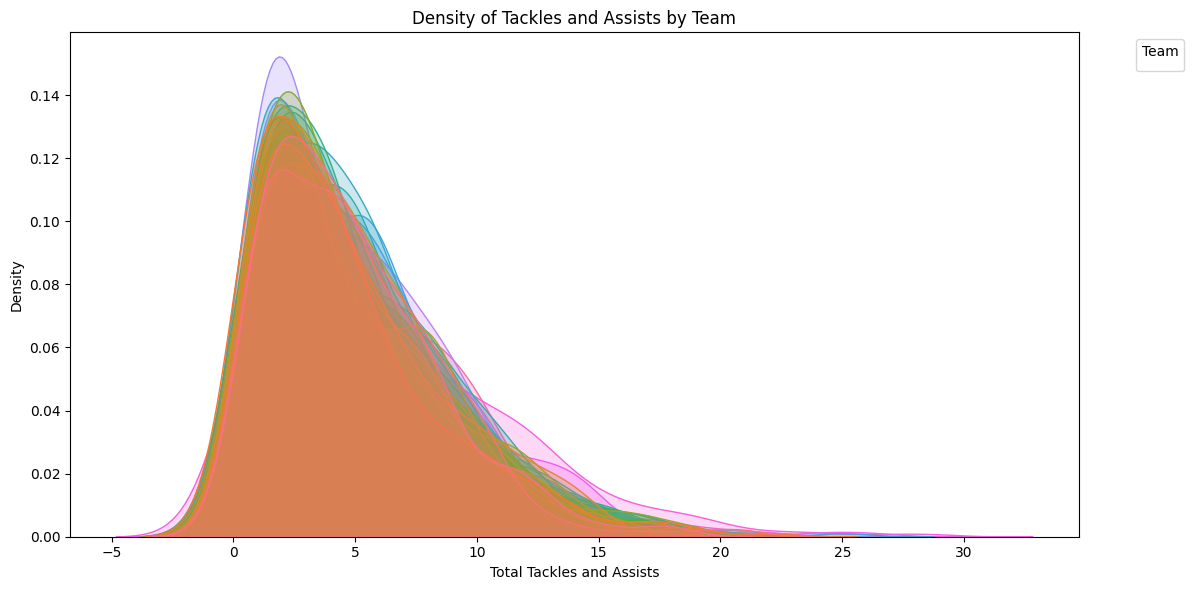

In [215]:
plt.figure(figsize=(12, 6))

sns.kdeplot(
    data=weekly_df_offense_filtered_2024,
    x='total_tackles_and_assists',
    hue='team',
    common_norm=False,
    fill=True
)

plt.title('Density of Tackles and Assists by Team')
plt.xlabel('Total Tackles and Assists')
plt.ylabel('Density')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

From the following chart arises the question, which are those teams with high densitity of tackles and assist.

On this chart we can visualize multiple things

🧠 Interpretation:
X-axis → Total Tackles and Assists:
This represents the number of tackles and assists a player made in a week.

Y-axis → Density:
This isn't a raw count — it's a smoothed estimate of how frequent certain values are. A higher peak means more players had that value.

Each colored curve = one team's distribution:
It shows how tackles/assists are spread among players in that team.

🔍 What you can observe:
Most teams peak around 2–6 tackles per player per week — this is the mode.

Distributions are right-skewed — a few players (likely defenders) get very high tackle counts (10+), but they’re rare.

Some teams have flatter curves → more variation among players.

Overlap is strong → most teams have similar distributions in general tackle performance.

In [216]:
weekly_df_offense_filtered_2024.groupby(['team'])[['total_tackles_and_assists']].describe().sort_index(level=['team'])

total_tackles_and_assists                                               
                         count      mean       std  min  25%  50%   75%   max
team                                                                         
ARI                      315.0  4.758730  3.814014  0.0  2.0  4.0  6.00  20.0
ATL                      305.0  4.518033  3.613822  0.0  2.0  4.0  6.00  21.0
BAL                      337.0  4.495549  3.660537  0.0  2.0  4.0  6.00  21.0
BUF                      349.0  4.948424  3.707352  0.0  2.0  4.0  7.00  18.0
CAR                      284.0  5.320423  3.704568  0.0  2.0  5.0  8.00  17.0
CHI                      299.0  5.080268  3.966332  0.0  2.0  4.0  7.00  22.0
CIN                      298.0  4.895973  3.943103  0.0  2.0  4.0  7.00  19.0
CLE                      299.0  4.923077  3.548906  0.0  2.0  4.0  7.00  16.0
DAL                      276.0  4.956522  3.566245  0.0  2.0  4.0  7.00  18.0
DEN                      319.0  5.172414  3.677023  0.0  2.0  5.0  7.00  20.0
DET                      304.0  4.322368  3.643525  0.0  2.0  3.0  6.00  19.0
GB                       318.0  4.839623  3.562343  0.0  2.0  4.0  7.00  18.0
HOU                      331.0  4.601208  3.623726  0.0  2.0  4.0  7.00  22.0
IND                      272.0  6.154412  4.934073  0.0  2.0  5.0  9.00  28.0
JAX                      296.0  4.827703  3.481775  0.0  2.0  4.0  7.00  18.0
KC                       330.0  4.754545  3.284447  0.0  2.0  4.0  6.00  17.0
LA                       333.0  5.045045  3.575487  0.0  2.0  4.0  8.00  18.0
LAC                      329.0  4.431611  3.672870  0.0  2.0  3.0  6.00  20.0
LV                       271.0  5.265683  3.627503  0.0  2.0  5.0  8.00  17.0
MIA                      273.0  4.897436  3.518401  0.0  2.0  4.0  7.00  21.0
MIN                      320.0  4.928125  3.968270  0.0  2.0  4.0  7.00  19.0
NE                       298.0  4.805369  3.419449  0.0  2.0  4.0  7.00  16.0
NO                       294.0  4.649660  3.557866  0.0  2.0  4.0  7.00  17.0
NYG                      288.0  5.447917  4.272601  0.0  2.0  5.0  7.00  26.0
NYJ                      302.0  4.728477  3.909157  0.0  2.0  4.0  7.00  25.0
PHI                      352.0  4.514205  3.893866  0.0  1.0  3.5  6.00  22.0
PIT                      316.0  4.791139  3.674976  0.0  2.0  4.0  7.00  18.0
SEA                      274.0  5.317518  3.889205  0.0  2.0  4.0  8.00  20.0
SF                       292.0  4.592466  3.546696  0.0  2.0  4.0  6.25  17.0
TB                       296.0  5.023649  3.832437  0.0  2.0  4.0  7.00  19.0
TEN                      267.0  5.411985  3.774012  0.0  2.0  5.0  8.00  22.0
WAS                      338.0  4.639053  3.564565  0.0  2.0  4.0  6.00  18.0

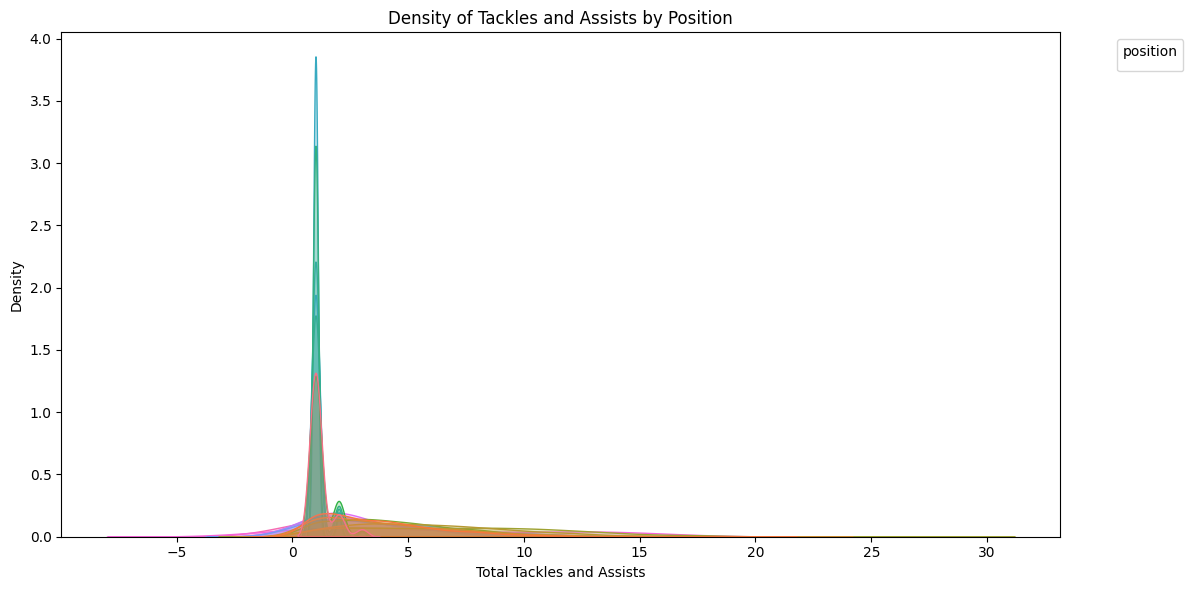

In [217]:
plt.figure(figsize=(12, 6))

sns.kdeplot(
    data=weekly_df_offense_filtered_2024,
    x='total_tackles_and_assists',
    hue='position',
    common_norm=False,
    fill=True
)

plt.title('Density of Tackles and Assists by Position')
plt.xlabel('Total Tackles and Assists')
plt.ylabel('Density')
plt.legend(title='position', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In the following chart we can see that the distribution by positin has a huge variability, meaning some specific possitions within a team have higher ammount of tackles and assists while others don't.

To explore this we are going to create a table.


In [218]:
weekly_df_offense_filtered_2024.groupby('position')[['total_tackles_and_assists']].describe().sort_values(('total_tackles_and_assists', 'mean'), ascending=False)

total_tackles_and_assists                                           \
                             count      mean       std  min  25%  50%   75%   
position                                                                      
LB                          1632.0  7.534926  4.696164  0.0  4.0  7.0  11.0   
SS                            27.0  6.333333  5.166460  0.0  1.5  6.0  11.5   
S                           1488.0  6.102151  3.726933  0.0  3.0  6.0   8.0   
CB                          1980.0  4.440909  2.926943  0.0  2.0  4.0   6.0   
DE                          1968.0  4.332317  3.354247  0.0  2.0  4.0   6.0   
OLB                           73.0  3.876712  2.910447  0.0  1.0  3.0   6.0   
DT                          2095.0  3.743198  2.754162  0.0  2.0  3.0   5.0   
FS                            73.0  3.534247  2.977145  0.0  1.0  2.0   5.0   
ILB                            9.0  3.444444  3.045944  1.0  1.0  2.0   5.0   
NT                            17.0  3.058824  2.435944  1.0  2.0  2.0   4.0   
G                             34.0  1.235294  0.495973  1.0  1.0  1.0   1.0   
QB                            26.0  1.192308  0.491466  1.0  1.0  1.0   1.0   
TE                            50.0  1.160000  0.421852  1.0  1.0  1.0   1.0   
RB                            66.0  1.121212  0.372730  1.0  1.0  1.0   1.0   
C                             11.0  1.090909  0.301511  1.0  1.0  1.0   1.0   
WR                           178.0  1.084270  0.333920  1.0  1.0  1.0   1.0   
T                             27.0  1.037037  0.192450  1.0  1.0  1.0   1.0   

                
           max  
position        
LB        28.0  
SS        16.0  
S         20.0  
CB        20.0  
DE        22.0  
OLB       12.0  
DT        20.0  
FS        14.0  
ILB       10.0  
NT        10.0  
G          3.0  
QB         3.0  
TE         3.0  
RB         3.0  
C          2.0  
WR         3.0  
T          2.0

This is a table that describes total tackles and assits by position.

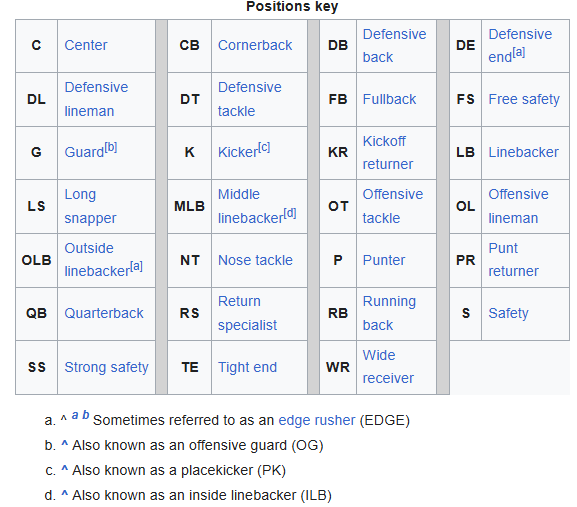

In [240]:
weekly_df_offense_filtered_2024.groupby('team')[['total_tackles_and_assists']].describe().sort_values(('total_tackles_and_assists', 'mean'), ascending=False)

total_tackles_and_assists                                               
                         count      mean       std  min  25%  50%   75%   max
team                                                                         
IND                      272.0  6.154412  4.934073  0.0  2.0  5.0  9.00  28.0
NYG                      288.0  5.447917  4.272601  0.0  2.0  5.0  7.00  26.0
TEN                      267.0  5.411985  3.774012  0.0  2.0  5.0  8.00  22.0
CAR                      284.0  5.320423  3.704568  0.0  2.0  5.0  8.00  17.0
SEA                      274.0  5.317518  3.889205  0.0  2.0  4.0  8.00  20.0
LV                       271.0  5.265683  3.627503  0.0  2.0  5.0  8.00  17.0
DEN                      319.0  5.172414  3.677023  0.0  2.0  5.0  7.00  20.0
CHI                      299.0  5.080268  3.966332  0.0  2.0  4.0  7.00  22.0
LA                       333.0  5.045045  3.575487  0.0  2.0  4.0  8.00  18.0
TB                       296.0  5.023649  3.832437  0.0  2.0  4.0  7.00  19.0
DAL                      276.0  4.956522  3.566245  0.0  2.0  4.0  7.00  18.0
BUF                      349.0  4.948424  3.707352  0.0  2.0  4.0  7.00  18.0
MIN                      320.0  4.928125  3.968270  0.0  2.0  4.0  7.00  19.0
CLE                      299.0  4.923077  3.548906  0.0  2.0  4.0  7.00  16.0
MIA                      273.0  4.897436  3.518401  0.0  2.0  4.0  7.00  21.0
CIN                      298.0  4.895973  3.943103  0.0  2.0  4.0  7.00  19.0
GB                       318.0  4.839623  3.562343  0.0  2.0  4.0  7.00  18.0
JAX                      296.0  4.827703  3.481775  0.0  2.0  4.0  7.00  18.0
NE                       298.0  4.805369  3.419449  0.0  2.0  4.0  7.00  16.0
PIT                      316.0  4.791139  3.674976  0.0  2.0  4.0  7.00  18.0
ARI                      315.0  4.758730  3.814014  0.0  2.0  4.0  6.00  20.0
KC                       330.0  4.754545  3.284447  0.0  2.0  4.0  6.00  17.0
NYJ                      302.0  4.728477  3.909157  0.0  2.0  4.0  7.00  25.0
NO                       294.0  4.649660  3.557866  0.0  2.0  4.0  7.00  17.0
WAS                      338.0  4.639053  3.564565  0.0  2.0  4.0  6.00  18.0
HOU                      331.0  4.601208  3.623726  0.0  2.0  4.0  7.00  22.0
SF                       292.0  4.592466  3.546696  0.0  2.0  4.0  6.25  17.0
ATL                      305.0  4.518033  3.613822  0.0  2.0  4.0  6.00  21.0
PHI                      352.0  4.514205  3.893866  0.0  1.0  3.5  6.00  22.0
BAL                      337.0  4.495549  3.660537  0.0  2.0  4.0  6.00  21.0
LAC                      329.0  4.431611  3.672870  0.0  2.0  3.0  6.00  20.0
DET                      304.0  4.322368  3.643525  0.0  2.0  3.0  6.00  19.0

In [242]:
positions = ['LB', 'SS', 'S', 'CB', 'DE', 'OLV']
teams = ['KC']
weekly_df_offense_filtered_2024[
    (weekly_df_offense_filtered_2024['position'].isin(positions)) &
     (weekly_df_offense_filtered_2024['team'].isin(teams)) # Replace 'LB' with the position you want
].groupby(['team', 'week'])[['total_tackles_and_assists']].describe().sort_values(
    ('total_tackles_and_assists', 'count'), ascending=False
)


total_tackles_and_assists                                            \
                              count      mean       std  min   25%  50%   75%   
team week                                                                       
KC   17                        17.0  4.588235  3.536574  0.0  3.00  3.0  6.00   
     3                         14.0  5.142857  4.054573  1.0  2.00  4.5  6.00   
     7                         14.0  4.500000  2.928638  0.0  3.00  3.5  5.50   
     20                        14.0  5.500000  3.391165  1.0  3.25  5.0  6.75   
     18                        14.0  5.714286  3.517617  1.0  3.25  5.0  8.25   
     16                        14.0  4.000000  2.773501  1.0  2.00  3.0  5.75   
     15                        14.0  5.071429  2.615465  0.0  4.25  5.5  6.00   
     9                         14.0  4.357143  2.817723  1.0  2.00  5.0  5.75   
     21                        14.0  4.642857  2.734597  1.0  3.00  4.0  6.00   
     13                        13.0  5.461538  4.254711  1.0  2.00  5.0  6.00   
     22                        13.0  5.769231  4.265244  1.0  3.00  5.0  7.00   
     8                         13.0  5.692308  3.682948  1.0  4.00  5.0  6.00   
     4                         12.0  5.083333  3.704011  1.0  3.00  4.0  6.25   
     2                         12.0  6.333333  2.994945  1.0  4.75  7.0  8.25   
     1                         12.0  5.916667  3.654594  1.0  3.50  5.5  8.50   
     5                         12.0  4.500000  4.562695  0.0  1.75  4.0  5.25   
     10                        12.0  5.250000  3.570714  1.0  2.75  4.0  7.50   
     11                        12.0  4.916667  3.287949  1.0  1.00  5.5  8.00   
     14                        12.0  4.500000  2.713602  1.0  3.00  3.0  6.25   
     12                        11.0  5.363636  2.110579  2.0  4.00  6.0  7.00   

                 
            max  
team week        
KC   17    12.0  
     3     13.0  
     7     12.0  
     20    15.0  
     18    13.0  
     16     9.0  
     15     9.0  
     9     10.0  
     21    10.0  
     13    17.0  
     22    15.0  
     8     15.0  
     4     15.0  
     2     10.0  
     1     12.0  
     5     17.0  
     10    13.0  
     11    10.0  
     14    10.0  
     12     8.0

In [250]:
positions = ['LB', 'SS', 'S', 'CB', 'DE', 'OLV']
teams = ['KC']
weekly_df_offense_filtered_2024[
    (weekly_df_offense_filtered_2024['position'].isin(positions)) &
     (weekly_df_offense_filtered_2024['team'].isin(teams)) # Replace 'LB' with the position you want
].groupby(['team', 'week'])[['total_tackles_and_assists']].describe().sort_values(
    ('total_tackles_and_assists', 'mean'), ascending=False
)


total_tackles_and_assists                                            \
                              count      mean       std  min   25%  50%   75%   
team week                                                                       
KC   2                         12.0  6.333333  2.994945  1.0  4.75  7.0  8.25   
     1                         12.0  5.916667  3.654594  1.0  3.50  5.5  8.50   
     22                        13.0  5.769231  4.265244  1.0  3.00  5.0  7.00   
     18                        14.0  5.714286  3.517617  1.0  3.25  5.0  8.25   
     8                         13.0  5.692308  3.682948  1.0  4.00  5.0  6.00   
     20                        14.0  5.500000  3.391165  1.0  3.25  5.0  6.75   
     13                        13.0  5.461538  4.254711  1.0  2.00  5.0  6.00   
     12                        11.0  5.363636  2.110579  2.0  4.00  6.0  7.00   
     10                        12.0  5.250000  3.570714  1.0  2.75  4.0  7.50   
     3                         14.0  5.142857  4.054573  1.0  2.00  4.5  6.00   
     4                         12.0  5.083333  3.704011  1.0  3.00  4.0  6.25   
     15                        14.0  5.071429  2.615465  0.0  4.25  5.5  6.00   
     11                        12.0  4.916667  3.287949  1.0  1.00  5.5  8.00   
     21                        14.0  4.642857  2.734597  1.0  3.00  4.0  6.00   
     17                        17.0  4.588235  3.536574  0.0  3.00  3.0  6.00   
     5                         12.0  4.500000  4.562695  0.0  1.75  4.0  5.25   
     14                        12.0  4.500000  2.713602  1.0  3.00  3.0  6.25   
     7                         14.0  4.500000  2.928638  0.0  3.00  3.5  5.50   
     9                         14.0  4.357143  2.817723  1.0  2.00  5.0  5.75   
     16                        14.0  4.000000  2.773501  1.0  2.00  3.0  5.75   

                 
            max  
team week        
KC   2     10.0  
     1     12.0  
     22    15.0  
     18    13.0  
     8     15.0  
     20    15.0  
     13    17.0  
     12     8.0  
     10    13.0  
     3     13.0  
     4     15.0  
     15     9.0  
     11    10.0  
     21    10.0  
     17    12.0  
     5     17.0  
     14    10.0  
     7     12.0  
     9     10.0  
     16     9.0

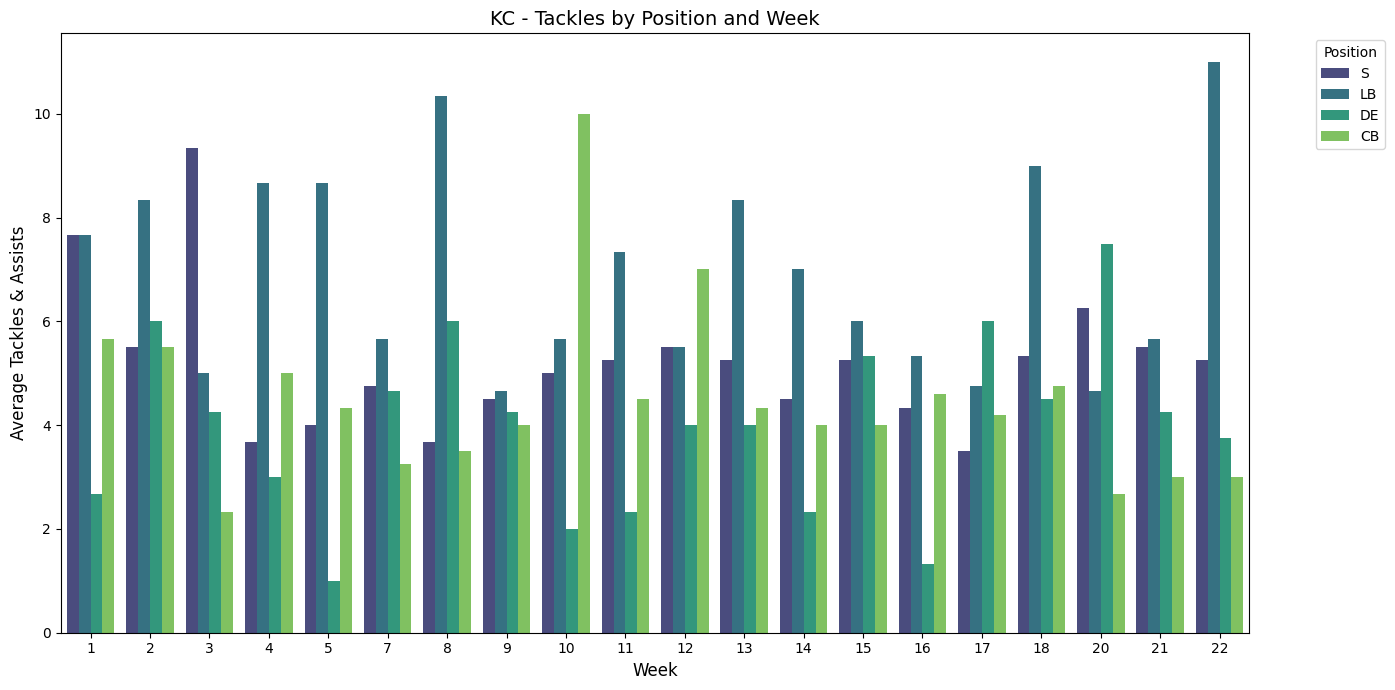

In [248]:
positions = ['LB', 'SS', 'S', 'CB', 'DE', 'OLV']
teams = ['KC']
filtered_df = weekly_df_offense_filtered_2024[
    (weekly_df_offense_filtered_2024['position'].isin(positions)) &
     (weekly_df_offense_filtered_2024['team'].isin(teams)) # Replace 'LB' with the position you want
]




plt.figure(figsize=(14, 7))
sns.barplot(
    data=filtered_df,
    x='week',
    y='total_tackles_and_assists',
    hue='position',
    estimator='mean',
    errorbar=None,
    palette='viridis'
)
plt.title('KC - Tackles by Position and Week', fontsize=14)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Average Tackles & Assists', fontsize=12)
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

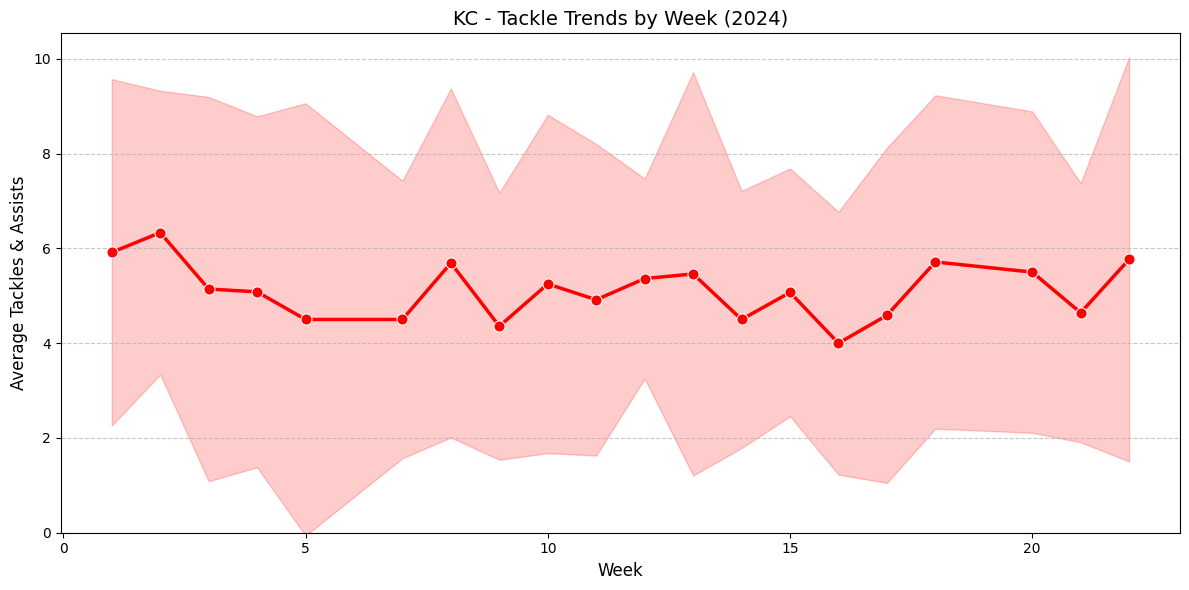

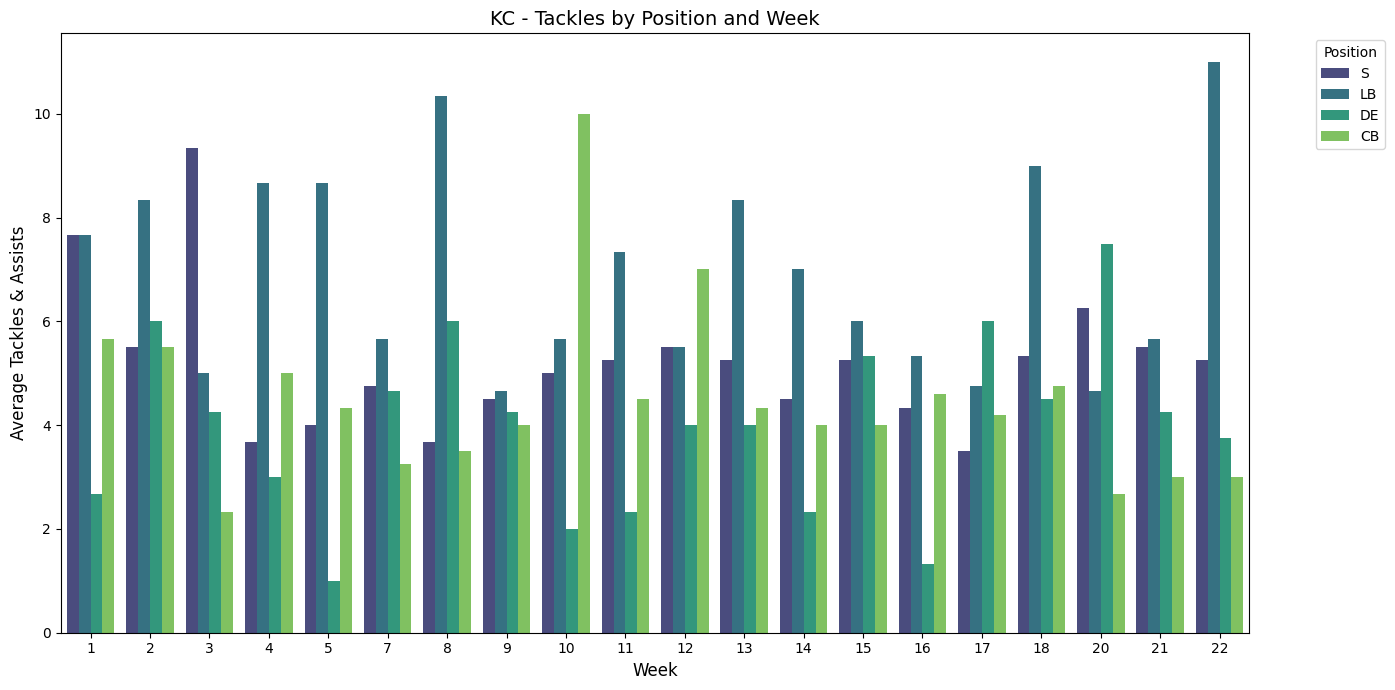

In [251]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=filtered_df,
    x='week',
    y='total_tackles_and_assists',
    estimator='mean',
    errorbar='sd',  # Shows variability
    marker='o',
    markersize=8,
    color='red',
    linewidth=2.5
)
plt.title('KC - Tackle Trends by Week (2024)', fontsize=14)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Average Tackles & Assists', fontsize=12)
plt.ylim(bottom=0)  # Start Y-axis at 0
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(
    data=filtered_df,
    x='week',
    y='total_tackles_and_assists',
    hue='position',
    estimator='mean',
    errorbar=None,
    palette='viridis'
)
plt.title('KC - Tackles by Position and Week', fontsize=14)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Average Tackles & Assists', fontsize=12)
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()